## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

## <span style="color:darkred">Avaliação Final</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Nessa avaliação será utilizado o dataset `smartphone_activity.csv` que contém 561 colunas, cujo objetivo é classificar uma entre 6 ações de uma pessoa com base em sensores disponíveis no smartphone. Vamos assumir um cenário com alta disponibilidade de exemplos não rotulados, e baixa de exemplos rotulados. Para tal, pré-treinaremos camadas de uma rede neural com dados não anotados, a qual posteriormente será usada para compor um modelo inicial de classificação.

Conforme código abaixo, use como características de entrada as 561 primeiras colunas e como classe a última coluna (activity). 

As tarefas a realizar são as seguintes:

1. **Prepare** os dados conforme o código fornecido (leia abaixo e estude o código para entender):
    * carregue o dataset e organize as features e rótulos
    * conjunto S = 2% dos dados iniciais como treinamento com rótulo (assumiremos que temos rótulos apenas para esses 2%), no formato par (x,y)
    * conjunto U = 50% dos dados iniciais como treinamento não anotado (note que S está contido em U), 
    * conjunto T = o restante dos 50% para teste, no formato par (x,y).<br><br>
    
1.  (3,0 pt) **Modelo A**: projete e treine um undercomplete autoencoder com dropout na entrada para pré-treinamento baseado em auto-supervisão. Esse autoencoder aprende a preencher os valores eliminados na camada de entrada. A arquitetura deve ter a seguinte estrutura:
    1. Encoder:
        * entrada com 561 valores
        * dropout com taxa de 0.25
        * normalização em batch
        * densa 256 neurônios, relu
        * densa 256 neurônios, relu
        * densa 64 neurônios, ativação linear 
        * normalização em batch (consideraremos essa camada como sendo o código produzido pelo encoder)
        * ativação relu
        * dropout 0.25
    2. Decoder:
        * densa 256 neurônios, ativação tanh
        * densa 256 neurônios, ativação tanh
        * densa 561 neurônios, ativação tanh
    * Usar Adam com taxa de aprendizado inicial de 0.005 e com decaimento exponencial a -0.1<br>
    * Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto **U**<br>
    * Exiba a perda final MSE após as 20 utilizando o conjunto **U** (use o evaluate para isso)<br>
    * Obtenha o código (saída do encoder relativa a normalização em batch após a camada de 64 dimensões) para os dados de treinamento (conjunto **U**) e armazene-o num array `code_train`. Exiba na tela esse código para a primeira instância de treinamento (índice 0)<br><br>
    
1. (3,5 pt)  **Modelo B**: rede neural profunda densa, utilizando como base o encoder do modelo A (inclusive seus pesos pré-treinados), e inserindo uma nova camada densa de classificação (em 6 classes) com ativação softmax (essa inicializada aleatoriamente). Porém **não** deve conter o primeiro dropout (logo após a camada de entrada) do encoder, ou seja a primeira camada dropout deve ser removida.<br>
    * A arquitetura deve ter portanto as seguintes camadas:
        * entrada
        * normalização em batch
        * densa 256 neurônios, relu
        * densa 256 neurônios, relu
        * densa 64 neurônios, ativação linear
        * normalização em batch
        * ativação relu
        * dropout 0.25
        * densa 6 neurônios, softmax
        
    * Utilizar Adam com taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.1
    * Treinar com perda entropia cruzada categórica por 50 épocas com batch size 16 
    * Compute como métricas, além da perda, precisão e revocação (precision / recall)<br><br>
    
1. (3,5 pt) **Avalie a rede neural de classificação** (Modelo B): 
    * Exiba o gráfico da precisão e revocação calculada no treinamento ao longo das épocas para o modelo B
    * Exiba precisão e revocação calculada no treinamento S e teste T (use evaluate no modelo B)<br><br>
    
1. **Bônus:** (+1 ponto extra) 
    * (0,5) *Análise de projeção das características*: visualize scatterplots com os 2 principais componentes obtidos do PCA com as classes dos exemplos atribuídas com cores ou marcadores diferentes. Projetar em 2D os seguintes espaços:
        1. scatterplot com projeção PCA do conjunto de S original (561 dimensões)
        1. scatterplot com projeção PCA do código (64 dimensões) do conjunto S após processado pelo "encoder" do *Modelo A* (code_train obtido no item/questão 2)
        1. scatterplot com projeção PCA do código (64 dimensões) do conjunto S após processado pelo "encoder" do *Modelo B* (treinado no item/questão 3)<br><br>    
    
    * (0,5) Obtenha um classificador SVM com kernel linear, treinado nos dados S obtendo sua representação do código (64 dimensões) da rede de classificação (modelo B). Avalie precisão e revocação no treinamento S e teste T.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import pandas as pd
# from google.colab import files
# Filename = "smartphone_activity_dataset.csv"   # colab
# Filepath = '/gdrive/MyDrive/Redes Neurais/AF/' + Filename
# df = pd.read_csv(Filepath)

df = pd.read_csv("smartphone_activity_dataset.csv") # jupyter

df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_553,feature_554,feature_555,feature_556,feature_557,feature_558,feature_559,feature_560,feature_561,activity
0,0.289,-0.0203,-0.1330,-0.995,-0.9830,-0.914,-0.995,-0.983,-0.924,-0.93500,...,-0.2990,-0.710,-0.1130,0.03040,-0.465,-0.0184,-0.841,0.180,-0.0586,5
1,0.278,-0.0164,-0.1240,-0.998,-0.9750,-0.960,-0.999,-0.975,-0.958,-0.94300,...,-0.5950,-0.861,0.0535,-0.00743,-0.733,0.7040,-0.845,0.180,-0.0543,5
2,0.280,-0.0195,-0.1130,-0.995,-0.9670,-0.979,-0.997,-0.964,-0.977,-0.93900,...,-0.3910,-0.760,-0.1190,0.17800,0.101,0.8090,-0.849,0.181,-0.0491,5
3,0.279,-0.0262,-0.1230,-0.996,-0.9830,-0.991,-0.997,-0.983,-0.989,-0.93900,...,-0.1170,-0.483,-0.0368,-0.01290,0.640,-0.4850,-0.849,0.182,-0.0477,5
4,0.277,-0.0166,-0.1150,-0.998,-0.9810,-0.990,-0.998,-0.980,-0.990,-0.94200,...,-0.3510,-0.699,0.1230,0.12300,0.694,-0.6160,-0.848,0.185,-0.0439,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.310,-0.0534,-0.0991,-0.288,-0.1410,-0.215,-0.356,-0.149,-0.232,0.18500,...,-0.3760,-0.751,-0.3370,0.34600,0.885,-0.6990,-0.652,0.275,0.1850,2
10295,0.363,-0.0392,-0.1060,-0.305,0.0281,-0.196,-0.374,-0.030,-0.270,0.18500,...,-0.3200,-0.700,-0.7370,-0.37300,-0.657,0.3230,-0.655,0.274,0.1820,2
10296,0.350,0.0301,-0.1160,-0.330,-0.0421,-0.250,-0.388,-0.133,-0.347,0.00747,...,-0.1190,-0.467,-0.1820,0.08860,0.697,0.3630,-0.655,0.274,0.1810,2
10297,0.238,0.0185,-0.0965,-0.323,-0.2300,-0.208,-0.392,-0.280,-0.289,0.00747,...,-0.2050,-0.618,0.4450,-0.81900,0.929,-0.0084,-0.660,0.265,0.1880,2


### Parte 1: separar dados

In [3]:
from tensorflow.keras.utils import to_categorical

rotulos = np.array(df['activity'])-1
features = np.array(df.iloc[:, :-1])

print(features.shape)
perc_train = 0.5
perc_rot = 0.02

n_train_S = int(features.shape[0]*perc_rot)
n_train_U = int(features.shape[0]*perc_train)
n_test = int(features.shape[0]*(1-perc_train))
print("Tamanho conjunto de treinamento (S): ", n_train_S)
print("Tamanho conjunto de treinamento não rotulado (U): ", n_train_U)
print("Tamanho conjunto de testes(T): ", n_test)

x_trainS = features[:n_train_S,:]
y_trainS = to_categorical(rotulos[:n_train_S], 6)
# rotulos discretos de treinamento
rot_trainS = rotulos[:n_train_S]

x_trainU = features[:n_train_U,:]
y_trainU = to_categorical(rotulos[:n_train_U], 6)

x_test = features[n_train_U:,:]
y_test = to_categorical(rotulos[n_train_U:], 6)
# rotulos discretos de teste
rot_test = rotulos[n_train_U:]

(10299, 561)
Tamanho conjunto de treinamento (S):  205
Tamanho conjunto de treinamento não rotulado (U):  5149
Tamanho conjunto de testes(T):  5149


### Parte 2: Modelo A

Encoder:
entrada com 561 valores
--dropout com taxa de 0.25
--normalização em batch
--densa 256 neurônios, relu
--densa 256 neurônios, relu
--densa 64 neurônios, ativação linear
--normalização em batch (consideraremos essa camada como sendo o código produzido pelo encoder)
--ativação relu
--dropout 0.25
Decoder:
--densa 256 neurônios, ativação tanh
--densa 256 neurônios, ativação tanh
--densa 561 neurônios, ativação tanh
--Usar Adam com taxa de aprendizado inicial de 0.005 e com decaimento exponencial a -0.1
--Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto U
--Exiba a perda final MSE após as 20 utilizando o conjunto U (use o evaluate para isso)
--Obtenha o código (saída do encoder relativa a normalização em batch após a camada de 64 dimensões) para os dados de treinamento (conjunto U) e armazene-o num array code_train. 
--Exiba na tela esse código para a primeira instância de treinamento (índice 0)

In [4]:
seed(1)
set_seed(2)

### instanciar modelo AE
def autoencoder(neurons=256, input_dim=features.shape[1], dropout_rate=0.25):
    # encoder
    input = keras.layers.Input(shape=(input_dim,), name='input')
    x = keras.layers.Dropout(dropout_rate, name='dropout_1')(input)
    x = keras.layers.BatchNormalization(name='bn_1')(x)
    x = keras.layers.Dense(neurons,activation='relu', name='layer_2')(x)
    x = keras.layers.Dense(neurons,activation='relu', name='layer_3')(x)
    x = keras.layers.Dense(int(neurons/4),activation='linear', name='layer_4')(x)
    x = keras.layers.BatchNormalization(name='codigo')(x)
    x = keras.layers.Activation(activation='relu', name='activation_1')(x)
    x = keras.layers.Dropout(dropout_rate, name='dropout_2')(x)
    # decoder
    x = keras.layers.Dense(neurons, activation='tanh', name='layer_5')(x)
    x = keras.layers.Dense(neurons, activation='tanh', name='layer_6')(x)
    output = keras.layers.Dense(input_dim, activation='tanh', name='output')(x)
    autoencoder = keras.models.Model(input, output)
    return autoencoder

modeloA = autoencoder(neurons=256, input_dim=features.shape[1], dropout_rate=0.25)
modeloA.summary()

### compilar
lr = 0.005
modeloA.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=lr))

### treinar
epochs = 20
batch_size = 16

def scheduler(epoch, lr):
    """função de decaimento da taxa de aprendizado"""
    return lr * tf.math.exp(-0.1)
callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

histA = modeloA.fit(x_trainU, x_trainU, callbacks=[callbacklr], batch_size=batch_size, epochs=epochs, verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 561)]             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 561)               0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 561)               2244      
_________________________________________________________________
layer_2 (Dense)              (None, 256)               143872    
_________________________________________________________________
layer_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
layer_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
codigo (BatchNormalization)  (None, 64)                256   

In [5]:
### avaliar MSE no treinamento
#Exiba a perda final MSE após as 20 utilizando o conjunto U (use o evaluate para isso)
score = modeloA.evaluate(x_trainU, x_trainU, verbose=0)
print("MSE treinamento - conjunto U: %.4f" % (score))

MSE treinamento - conjunto U: 0.0185


In [6]:
### obter código 64d da normalizacao em batch do treinamento
code_model_A = keras.models.Model(inputs=modeloA.input, outputs=modeloA.get_layer('codigo').output)
code_train_model_A_cjto_S = np.asarray(code_model_A.predict(x_trainS))

In [7]:
### exibir código da primeira instancia do treinamento
code_train_model_A_cjto_S[0]

array([-0.14696082,  0.01260294,  0.06833673,  0.5220796 ,  0.2530887 ,
       -0.66171324, -0.5567696 , -0.29384965,  0.39635375, -1.2673304 ,
       -0.63285583, -0.6024664 ,  0.4854924 , -1.0070804 , -1.2669904 ,
       -0.6230869 , -0.99068934, -0.93855524,  0.30709168,  0.38285637,
        0.22502899,  0.20517325, -0.8669499 ,  1.3723116 , -0.09080589,
        0.11902407, -0.5096868 ,  0.22659081,  0.33197898, -0.9625013 ,
       -0.18377636,  0.6215528 , -1.1593978 ,  0.48628575, -0.22224168,
       -0.1831738 , -0.32159427,  0.24246514, -0.8313751 ,  0.1265783 ,
       -0.7917011 , -0.11754738, -0.23672041,  0.06783973, -0.8257164 ,
       -0.72728187,  1.1910732 ,  0.7023989 , -0.11985949,  0.4773878 ,
        0.00864741,  0.13728178,  0.41995856,  0.08500125,  0.71895593,
        0.56694216, -0.71133465,  0.8587649 ,  0.45613027,  0.82883465,
        0.8449845 ,  0.00280821,  0.8929026 , -0.44578773], dtype=float32)

### Parte 3: Modelo B

Modelo B: rede neural profunda densa, utilizando como base o encoder do modelo A (inclusive seus pesos pré-treinados), e inserindo uma nova camada densa de classificação (em 6 classes) com ativação softmax (essa inicializada aleatoriamente). Porém não deve conter o primeiro dropout (logo após a camada de entrada) do encoder, ou seja a primeira camada dropout deve ser removida.

A arquitetura deve ter portanto as seguintes camadas:

entrada
normalização em batch
densa 256 neurônios, relu
densa 256 neurônios, relu
densa 64 neurônios, ativação linear
normalização em batch
densa ativação relu
dropout 0.25
densa 6 neurônios, softmax

--Utilizar Adam com taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.1

--Treinar com perda entropia cruzada categórica por 50 épocas com batch size 16

--Compute como métricas, além da perda, precisão e revocação (precision / recall)

In [8]:
### criar novo modelo usando encoder pré-treinado do modelo A

# dica: obter lista de camadas
layers = [l for l in modeloA.layers]
layers

In [9]:
# montar novo modelo com nova camada de entrada
# Criando um modelo temporário pegando todas as camadas do ModeloA menos o dropout_1
model_temp = keras.Sequential([layer for layer in modeloA.layers if layer.name != 'dropout_1'])
model_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn_1 (BatchNormalization)    (None, 561)               2244      
_________________________________________________________________
layer_2 (Dense)              (None, 256)               143872    
_________________________________________________________________
layer_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
layer_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
codigo (BatchNormalization)  (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [10]:
# adicionar camadas anteriores usando novo_modelo.add(layers[i])
# Criando o modeloB pegando o model_temp e tirando as últimas camadas
modeloB = keras.Sequential()
modeloB.add(keras.Input(shape=(features.shape[1],)))
for layer in model_temp.layers[:-5]:
            modeloB.add(layer)
modeloB.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn_1 (BatchNormalization)    (None, 561)               2244      
_________________________________________________________________
layer_2 (Dense)              (None, 256)               143872    
_________________________________________________________________
layer_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
layer_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
codigo (BatchNormalization)  (None, 64)                256       
Total params: 228,612
Trainable params: 227,362
Non-trainable params: 1,250
_________________________________________________________________


In [11]:
# Adicionando novas camadas
modeloB.add(keras.layers.Dense(6, activation='softmax'))
modeloB.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn_1 (BatchNormalization)    (None, 561)               2244      
_________________________________________________________________
layer_2 (Dense)              (None, 256)               143872    
_________________________________________________________________
layer_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
layer_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
codigo (BatchNormalization)  (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 229,002
Trainable params: 227,752
Non-trainable params: 1,250
____________________________________________

In [12]:
# compilar modelo B
lr = 0.001
modeloB.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr),
                metrics = [tf.keras.metrics.Precision(name="Precision"), 
                           tf.keras.metrics.Recall(name="Recall")]
                )

In [13]:
# treinar modelo B
epochs = 50
batch_size = 16

def scheduler(epoch, lr):
    """função de decaimento da taxa de aprendizado"""
    return lr * tf.math.exp(-0.1)
callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

histB = modeloB.fit(x_trainS, y_trainS, callbacks=[callbacklr], batch_size=batch_size, epochs=epochs, verbose=1)
#histB = modeloB.fit(x_trainU, y_trainU, callbacks=[callbacklr], batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/50
13/13 [==============================] - 1s 2ms/step - loss: 1.5405 - Precision: 0.5263 - Recall: 0.0488    
Epoch 2/50
13/13 [==============================] - 0s 2ms/step - loss: 0.9100 - Precision: 0.9529 - Recall: 0.3951
Epoch 3/50
13/13 [==============================] - 0s 2ms/step - loss: 0.6351 - Precision: 0.9530 - Recall: 0.6927
Epoch 4/50
13/13 [==============================] - 0s 2ms/step - loss: 0.4634 - Precision: 0.9653 - Recall: 0.8146
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 0.3780 - Precision: 0.9784 - Recall: 0.8829
Epoch 6/50
13/13 [==============================] - 0s 2ms/step - loss: 0.2955 - Precision: 0.9893 - Recall: 0.9024
Epoch 7/50
13/13 [==============================] - 0s 2ms/step - loss: 0.3314 - Precision: 0.9630 - Recall: 0.8878
Epoch 8/50
13/13 [==============================] - 0s 2ms/step - loss: 0.2502 - Precision: 0.9697 - Recall: 0.9366
Epoch 9/50
13/13 [==============================] - 0s 2ms/step - lo

In [14]:
### obter código 64d da normalizacao em batch do treinamento
code_model_B = keras.models.Model(inputs=modeloA.input, outputs=modeloB.get_layer('codigo').output)
code_train_model_B_cjto_S = np.asarray(code_model_B.predict(x_trainS))

In [15]:
### obter código 64d da normalizacao em batch do treinamento
code_model_B = keras.models.Model(inputs=modeloA.input, outputs=modeloB.get_layer('codigo').output)
code_train_model_B_cjto_T = np.asarray(code_model_B.predict(x_test))

### Parte 4: Avaliação da rede neural de classificação

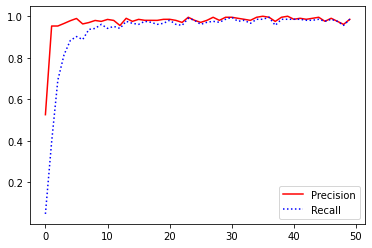

In [16]:
# exibir grafico com precision e recall das épocas
plt.plot(histB.history['Precision'], 'r')
plt.plot(histB.history['Recall'], 'b:')
plt.legend(["Precision", "Recall"])
plt.show()


In [17]:
# avalie precision e recall final no treinamento/teste

score_train = modeloB.evaluate(x_trainS, y_trainS, verbose=0)
score_test = modeloB.evaluate(x_test, y_test, verbose=0)

print("Precision treinamento - conjunto S: %.4f" % (score_train[1]))
print("Recall treinamento - conjunto S: %.4f" % (score_train[2]))
print()
print("Precision teste - conjunto T: %.4f" % (score_test[1]))
print("Recall teste - conjunto T: %.4f" % (score_test[2]))


Precision treinamento - conjunto S: 1.0000
Recall treinamento - conjunto S: 1.0000

Precision teste - conjunto T: 0.8364
Recall teste - conjunto T: 0.7297


### Bônus

#### 1: Análise do espaço de características aprendido (0,5 pt)

(0,5) Análise de projeção das características: visualize scatterplots com os 2 principais componentes obtidos do PCA com as classes dos exemplos atribuídas com cores ou marcadores diferentes. Projetar em 2D os seguintes espaços:

scatterplot com projeção PCA do conjunto de S original (561 dimensões)
scatterplot com projeção PCA do código (64 dimensões) do conjunto S após processado pelo "encoder" do Modelo A (code_train obtido no item/questão 2)
scatterplot com projeção PCA do código (64 dimensões) do conjunto S após processado pelo "encoder" do Modelo B (treinado no item/questão 3)

In [18]:
from sklearn.decomposition import PCA

In [19]:
# Projetando os 2 componentes principais para o conjunto "S" original com 561 d
pca = PCA(n_components=2)
pca.fit(x_trainS)
pca_train = pca.transform(x_trainS)

print('\tDados x features antes do PCA: ', x_trainS.shape)
print('\tDados x features obtidas após PCA: ', pca_train.shape)

	Dados x features antes do PCA:  (205, 561)
	Dados x features obtidas após PCA:  (205, 2)


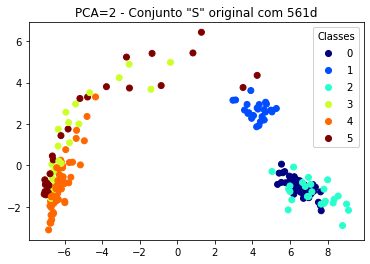

In [20]:
# código exemplo para scatterplot (sendo pca_train o array com dados projetados, e rot_train rotulos discretos)
fig, ax = plt.subplots()
scatter = ax.scatter(pca_train[:,0], pca_train[:,1], c=rot_trainS, cmap="jet")
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.title('PCA=2 - Conjunto "S" original com 561d');

In [21]:
# Projetando os 2 componentes principais para o conjunto "S" com o código do modelo A com 64 d
pca = PCA(n_components=2)
pca.fit(code_train_model_A_cjto_S)
pca_train = pca.transform(code_train_model_A_cjto_S)

print('\tDados x features antes do PCA: ', code_train_model_A_cjto_S.shape)
print('\tDados x features obtidas após PCA: ', pca_train.shape)

	Dados x features antes do PCA:  (205, 64)
	Dados x features obtidas após PCA:  (205, 2)


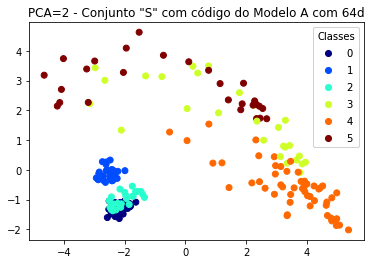

In [22]:
# código exemplo para scatterplot (sendo pca_train o array com dados projetados, e rot_train rotulos discretos)
fig, ax = plt.subplots()
scatter = ax.scatter(pca_train[:,0], pca_train[:,1], c=rot_trainS, cmap="jet")
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.title('PCA=2 - Conjunto "S" com código do Modelo A com 64d');

In [23]:
# Projetando os 2 componentes principais para o conjunto "S" com o código do modelo B com 64 d
pca = PCA(n_components=2)
pca.fit(code_train_model_B_cjto_S)
pca_train = pca.transform(code_train_model_B_cjto_S)

print('\tDados x features antes do PCA: ', code_train_model_B_cjto_S.shape)
print('\tDados x features obtidas após PCA: ', pca_train.shape)

	Dados x features antes do PCA:  (205, 64)
	Dados x features obtidas após PCA:  (205, 2)


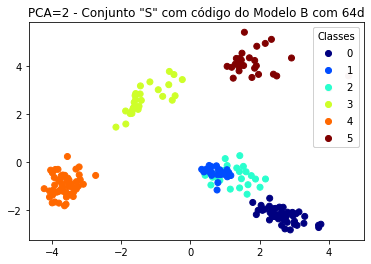

In [24]:
# código exemplo para scatterplot (sendo pca_train o array com dados projetados, e rot_train rotulos discretos)
fig, ax = plt.subplots()
scatter = ax.scatter(pca_train[:,0], pca_train[:,1], c=rot_trainS, cmap="jet")
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.title('PCA=2 - Conjunto "S" com código do Modelo B com 64d');

#### 2: SVM no código aprendido (0,5 pt)

(0,5) Obtenha um classificador SVM com kernel linear, treinado nos dados S obtendo sua representação do código (64 dimensões) da rede de classificação (modelo B). Avalie precisão e revocação no treinamento S e teste T.

In [25]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [26]:
clf = SVC (kernel='linear')
clf.fit(code_train_model_B_cjto_S, rot_trainS)

SVC(kernel='linear')

In [27]:
y_pred_S = clf.predict(code_train_model_B_cjto_S)
y_pred_T = clf.predict(code_train_model_B_cjto_T)

In [28]:
# Métricas
prec_S = precision_score(rot_trainS, y_pred_S, average='micro')
rev_S = recall_score(rot_trainS, y_pred_S, average='micro')
prec_T = precision_score(rot_test, y_pred_T, average='micro')
rev_T = recall_score(rot_test, y_pred_T, average='micro')

print("Precisão treinamento - conjunto S: %.4f" % (prec_S))
print("Revocação treinamento - conjunto S: %.4f" % (rev_S))
print()
print("Precisão teste - conjunto T: %.4f" % (prec_T))
print("Revocação teste - conjunto T: %.4f" % (rev_T))

Precisão treinamento - conjunto S: 1.0000
Revocação treinamento - conjunto S: 1.0000

Precisão teste - conjunto T: 0.7637
Revocação teste - conjunto T: 0.7637
